In [ ]:
!pip install scikit-surprise
#!pip install holidays==0.9.8 fbprophet
        
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Colab Notebooks

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import source.datasets as ds
import source.forecast as ft

## Data load

In [0]:
data = ds.get_movielens('20m')

movies = data.movies
ratings = data.ratings
tags = data.tags

## Most popular movies in dataset
These movies will be used to validate forecasting techniques.

In [0]:
rating_counts = ratings.groupby('movieId')['y'].agg(['count', 'mean']).sort_values('count', ascending=False)
most_popular_movies = rating_counts.reset_index().merge(movies, on='movieId')[:10].reset_index()
most_popular_movies.loc[:, ['movieId', 'title', 'genres', 'count', 'mean']].reset_index()


,index,movieId,title,genres,count,mean
0,0,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,67310,4.174231
1,1,356,Forrest Gump (1994),Comedy|Drama|Romance|War,66172,4.029000
2,2,318,"Shawshank Redemption, The (1994)",Crime|Drama,63366,4.446990
3,3,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,63299,4.177057
4,4,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,59715,3.664741
5,5,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,54502,4.190672
6,6,110,Braveheart (1995),Action|Drama|War,53769,4.042534
7,7,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,52244,3.931954
8,8,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,51334,4.187186
9,9,527,Schindler's List (1993),Drama|War,50054,4.310175


# Number of ratings per year

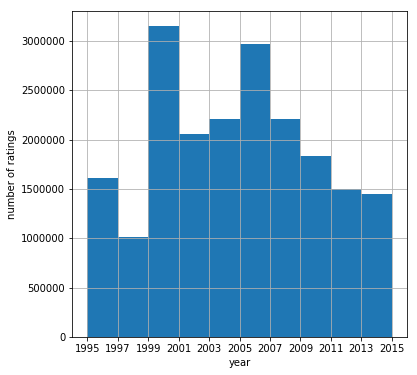

In [0]:
plt.figure(figsize=(6, 6))
plt.xticks(range(1995, 2016,2))
plt.xlabel('year')
plt.ylabel('number of ratings')

ratings.ds.dt.year.hist(bins = np.arange(1995, 2016, 2))
plt.savefig('images/year_rating_count_histogram.png')

# Cumulative Number of ratings per year

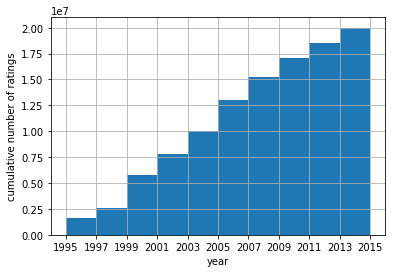

In [0]:
plt.xticks(range(1995, 2016,2))
plt.xlabel('year')
plt.ylabel('cumulative number of ratings')

ratings.ds.dt.year.hist(bins = np.arange(1995, 2016, 2), cumulative=True)
plt.savefig('images/year_rating_count_cumulative_histogram.png')

# Global mean over time

In [0]:
aggregated = ft.aggregate_by_days(ratings, 365)

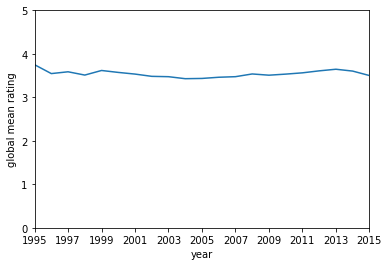

In [0]:
aggregated['year'] = aggregated.ds.dt.year
aggregated.dropna().plot(x='year', y='y', xticks=np.arange(1995, 2016, 2), legend=False, ylim=(0, 5.0))
plt.xlabel('year')
plt.ylabel('global mean rating')
plt.savefig('images/global_mean_over_years.png')

# Median number of ratings per user

In [0]:
ratings.groupby('userId').count().y.median()

68.0

# Number of ratings per user histogram

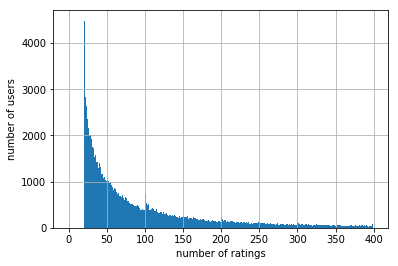

In [0]:
ratings.groupby('userId').count().y.hist(bins=np.arange(400))
plt.xlabel('number of ratings')
plt.ylabel('number of users')
plt.savefig('images/user_ratings_distribution_histogram.png')

# Distribution of ratings

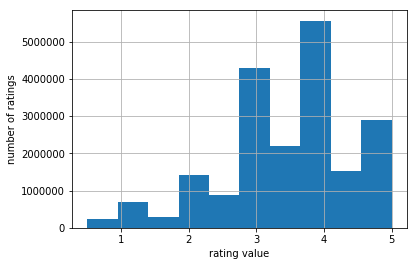

In [0]:
ratings.y.hist()
plt.xlabel('rating value')
plt.ylabel('number of ratings')
plt.savefig('images/ratings_distribution_histogram.png')

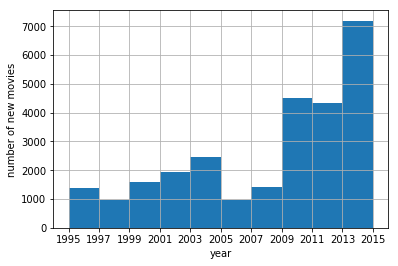

In [0]:
plt.xticks(range(1995, 2016,2))
ratings.groupby('movieId').year.min().hist(bins = np.arange(1995, 2016, 2))
plt.xlabel('year')
plt.ylabel('number of new movies')
plt.savefig('images/number_of_new_movies_per_year.png')

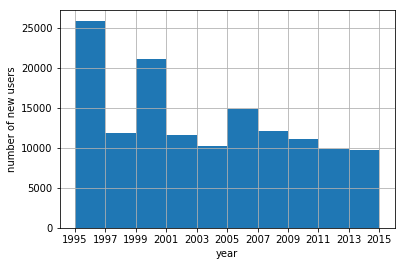

In [0]:
plt.xticks(range(1995, 2016,2))
ratings.groupby('userId').year.min().hist(bins = np.arange(1995, 2016, 2))
plt.xlabel('year')
plt.ylabel('number of new users')
plt.savefig('images/number_of_new_users_per_year.png')

Average number of years of user activity

In [0]:
(ratings.groupby('userId').year.max() - ratings.groupby('userId').year.min() + 1).mean()

1.55426628060624

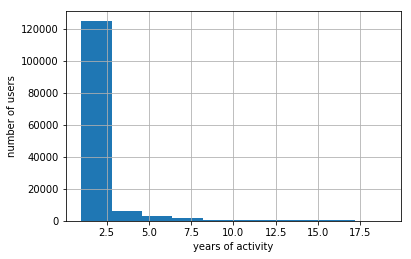

In [0]:
(ratings.groupby('userId').year.max() - ratings.groupby('userId').year.min() + 1).hist()
plt.xlabel('years of activity')
plt.ylabel('number of users')
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('images/number_of_users_per_activity_year.png', bbox_inches = "tight")

Total number of days

In [0]:
(ratings.ds.max() - ratings.ds.min())

Timedelta('7385 days 18:53:18')

# Seasonality
Average item rating for each month

In [0]:
ratings['month'] = ratings.ds.dt.month

In [0]:
print(ratings[ratings.movieId == 356].groupby('month').y.agg(['mean']))

           mean
month          
1      4.024618
2      4.014841
3      3.921970
4      4.008909
5      4.025301
6      4.064766
7      4.071546
8      4.055299
9      4.031244
10     3.992805
11     4.057112
12     4.037561


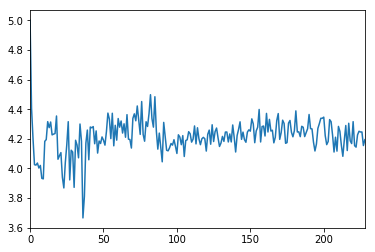

In [0]:
ratings[ratings.movieId == 296].groupby(['year', 'month']).y.mean().reset_index().y.plot()

In [0]:
def rename_to_prophet_ts(rates):
    
    if 'y' in rates.columns and 'ds' in rates.columns:
        return rates
    
    return rates.rename(index=str, columns={"rating": "y", "timestamp": "ds"})

# Aggregating ratings

The biggest problem with predicting ratings is their irregularity. It is hard to observe any patterns in time series when we see all possible values (1.0-5.0) of ratings each day, or even each hour. To overcome this, ratings will be aggragated into bins and then mean of ratings in each bin will be used to predict future mean rating. I'll use few aggregating techniques and compare them.

### Aggregating by timespan
First, I'll aggregate movie ratings by fixed timespan, for example one month or half of year. Each datapoint in time series is a mean of ratings made in given timespan.

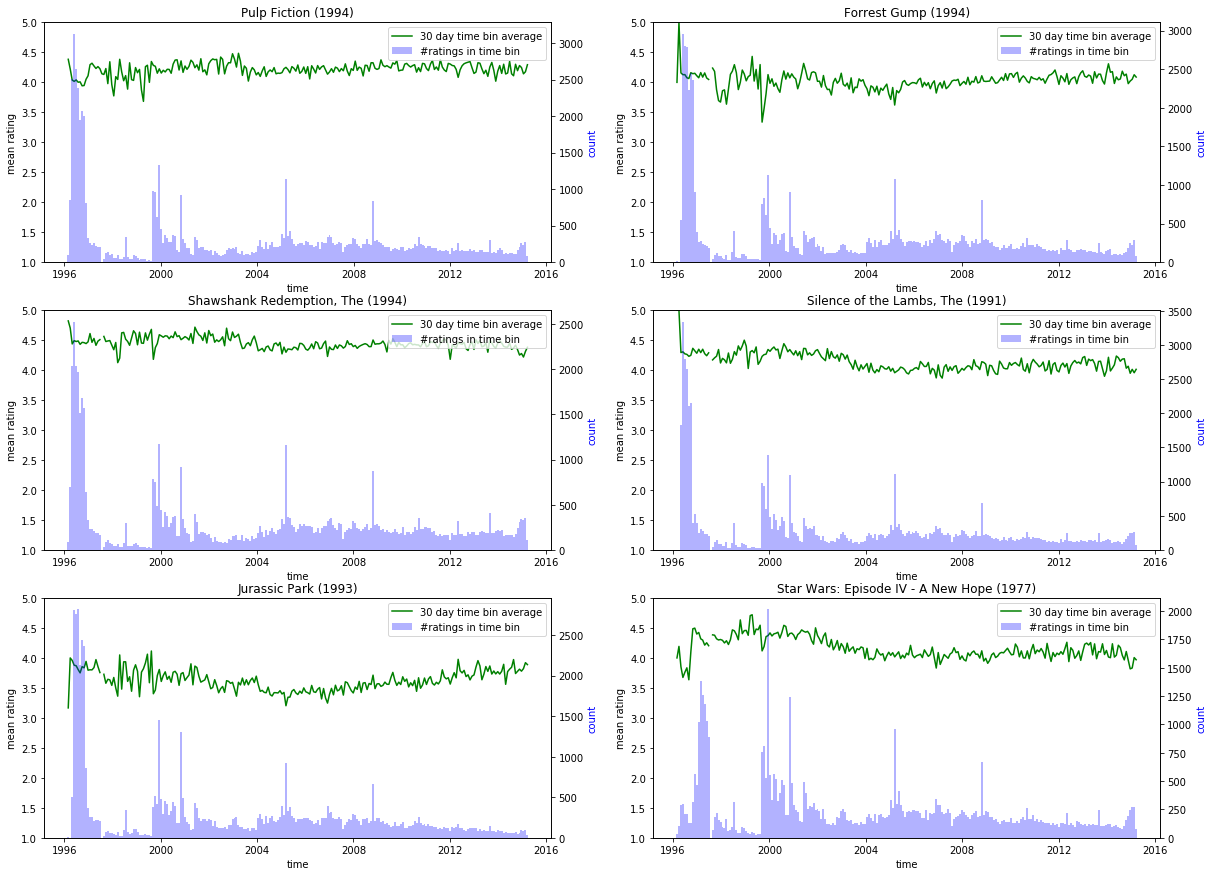

In [0]:
timespan_days = 30

plt.figure(figsize=(20, 15))
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
for index, movie_row in most_popular_movies[:6].iterrows():
    plt.subplot(3, 2, index+1)

    current_movie_id = movie_row['movieId']
    current_movie_ratings = ratings[ratings['movieId'] == current_movie_id]
    aggregated = ft.aggregate_by_days(current_movie_ratings, timespan_days)
    
    ft.plot_aggregated_ratings(aggregated, timespan_days, title=movie_row['title'])
    
    #current_movie_id = movies[movies['title'].str.contains(movie_title)].iloc[0]['movieId']
    #aggregated = ft.get_smooth_by_id(ratings, current_movie_id, timespan=timespan_days, halflife=30, min_count=1, min_cum_count=0)  
    
    #ft.plot_aggregated_ratings(aggregated, timespan_days, title=movie_title)
plt.savefig('images/popular_movies_aggregated_by_30_days.png', bbox_inches='tight')

### Aggregating by timespan with EWMA

Using Exponentially-weighted moving average to smooth data. Here I compare few values of timespan aggregating and halflives. Also, I remove all days with number of votes less than 5 and all days with cumulative sum of number of votes (since first vote for the movie) less than 1000. It allows to delete outliers

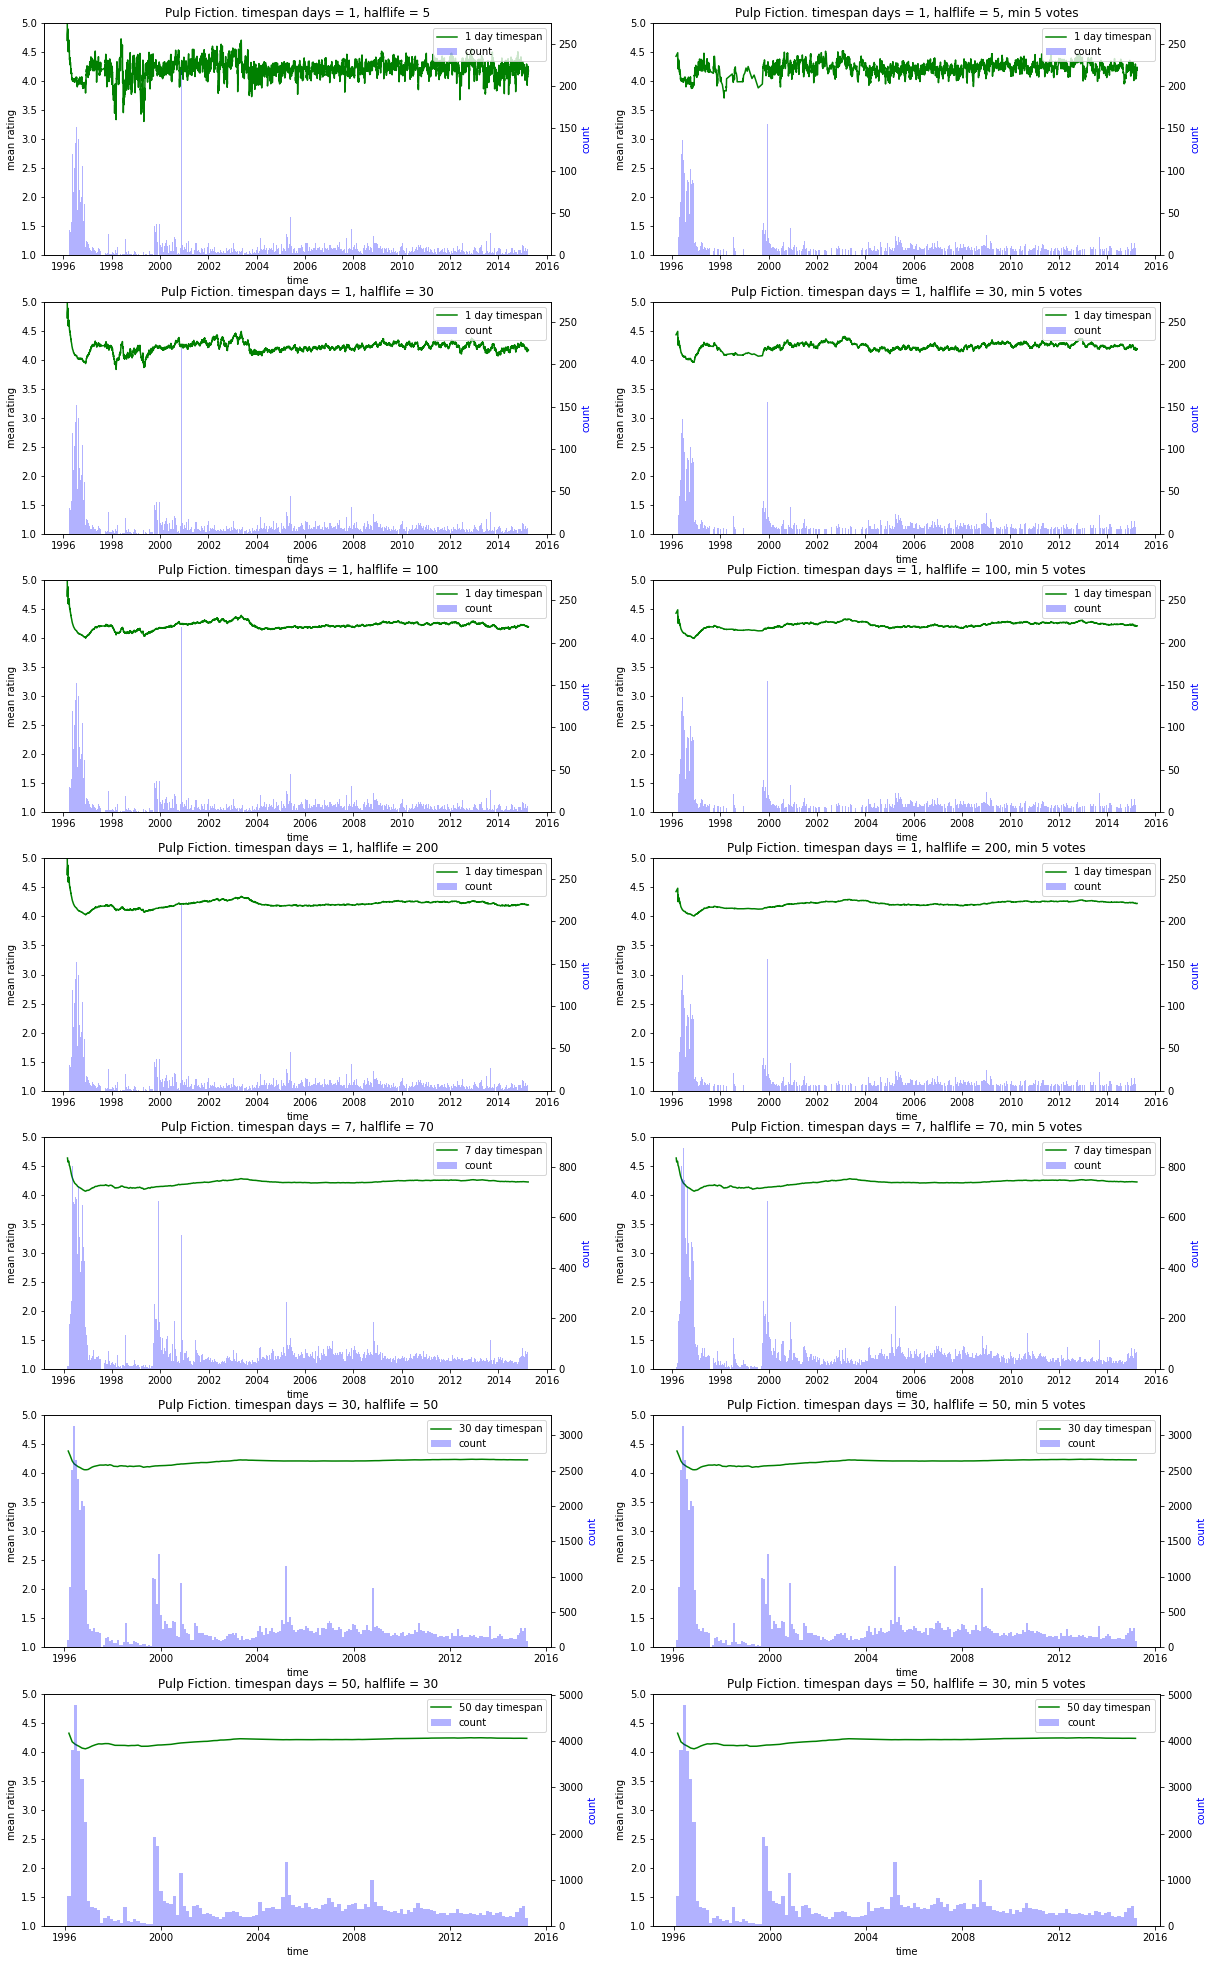

In [0]:
plt.figure(figsize=(20, 35))
for index, (timespan_days, halflife) in enumerate([(1,5), (1, 30), (1, 100), (1, 200), (7,70), (30, 50), (50, 30)]):
  for i in range(2):
    
    plt.subplot(7, 2, 2*index+1+i)

    current_movie_id = 296 # Pulp fiction
    if i == 1:
      aggregated = ft.get_smooth_by_id(ratings, current_movie_id, timespan=timespan_days, halflife=halflife, min_count=5, min_cum_count=0)  
    else:
      aggregated = ft.get_smooth_by_id(ratings, current_movie_id, timespan=timespan_days, halflife=halflife)  

    title = 'Pulp Fiction. timespan days = {}, halflife = {}'.format(timespan_days, halflife)
    if i == 1:
      title = title + ', min 5 votes'
    ft.plot_aggregated_ratings(aggregated, timespan_days, title=title)

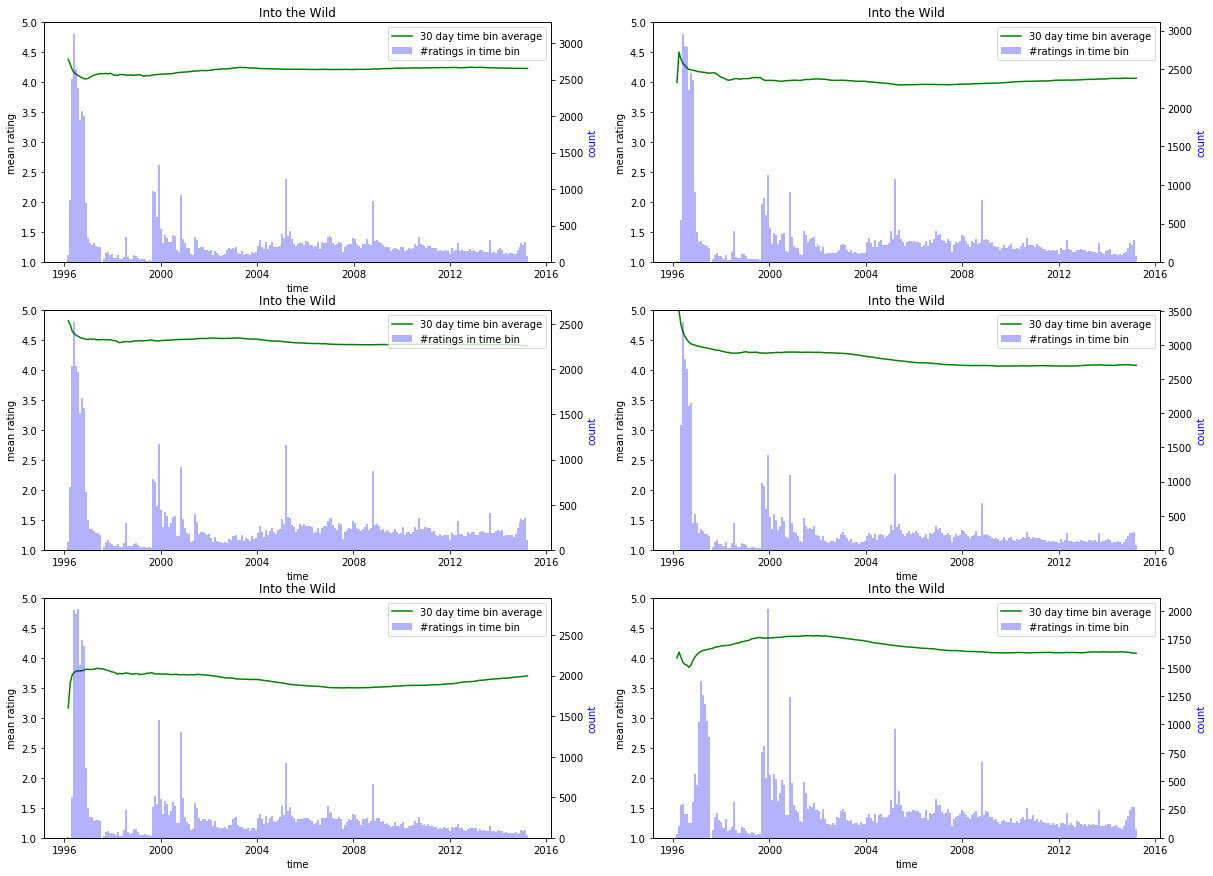

In [0]:
timespan_days = 30

plt.figure(figsize=(20, 15))
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
for index, movie_row in most_popular_movies[:6].iterrows():
    plt.subplot(3, 2, index+1)

    current_movie_id = movie_row['movieId']
    aggregated = ft.get_smooth_by_id(ratings, current_movie_id, timespan=timespan_days, halflife=50, min_count=1, min_cum_count=0)  
    
    ft.plot_aggregated_ratings(aggregated, timespan_days, title=movie_title)
plt.savefig('images/popular_movies_aggregated_by_30_days_smoothed.png', bbox_inches='tight')

### Aggregating newer movies

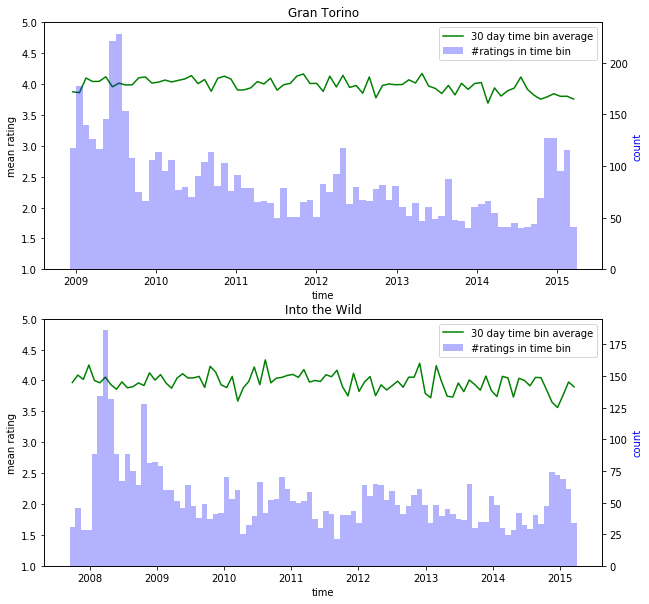

In [0]:
#movie_titles = ["Inception", "Django Unchained", "Gran Torino", "Into the Wild"]
movie_titles = ["Gran Torino", "Into the Wild"]
timespan_days = 30

plt.figure(figsize=(10,10))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=20.0)
for idx, movie_title in enumerate(movie_titles):
    plt.subplot(2,1,idx+1)
    
    current_movie_id = movies[movies['title'].str.contains(movie_title)].iloc[0]['movieId']
    current_movie_ratings = ratings[ratings['movieId'] == current_movie_id]
    aggregated = ft.aggregate_by_days(current_movie_ratings, timespan_days)
    
    ft.plot_aggregated_ratings(aggregated, timespan_days, title=movie_title)
    
plt.savefig('images/new_movies_aggregated_by_30_days.png')

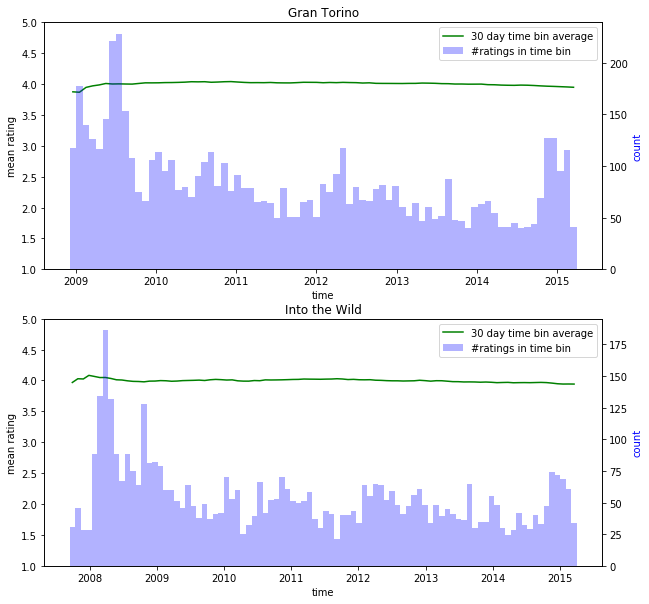

In [0]:
#movie_titles = ["Inception", "Django Unchained", "Gran Torino", "Into the Wild"]
movie_titles = ["Gran Torino", "Into the Wild"]
timespan_days = 30

plt.figure(figsize=(10,10))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=20.0)
for idx, movie_title in enumerate(movie_titles):
    plt.subplot(2,1,idx+1)
    
    current_movie_id = movies[movies['title'].str.contains(movie_title)].iloc[0]['movieId']
    aggregated = ft.get_smooth_by_id(ratings, current_movie_id, timespan=timespan_days, halflife=50, min_count=1, min_cum_count=0)  
    
    ft.plot_aggregated_ratings(aggregated, timespan_days, title=movie_title)
    
plt.savefig('images/new_movies_aggregated_by_30_days_smoothed.png')